## Exp 01. Multi-Property Control

This file provides source codes for multi-property control experiment and removal fragment statistics analysis.

First, pre-selected 100 molecules are queried to DeepBioisostere to yield 100 modified structures for each input molecule and property control condition.

Then, for three test molecules, removal fragments are analyzed and their statistics is visualized.

### Basic package loading

In [11]:
import time
import json
import sys
import os
import os.path as op
from pathlib import Path
from copy import deepcopy
from datetime import datetime
from pathlib import Path
from typing import Dict, List
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from tqdm import tqdm

from conditioning import Conditioner
from generate import Generator
from model import DeepBioisostere
from property import calc_logP, calc_Mw, calc_QED, calc_SAscore

pd.options.mode.chained_assignment = None

In [12]:
SMILES = str
TO_UPPERCASE = {"logp": "logP", "mw": "Mw", "qed": "QED", "sa": "SA"}
DELTA_PROPS = {
    "Mw": r"$\Delta Mw$",
    "logP": r"$\Delta logP$",
    "QED": r"$\Delta QED$",
    "SA": r"$\Delta SA$",
}
DE_DELTA_PROPS = {
    r"$\Delta Mw$": "Mw",
    r"$\Delta logP$": "logP",
    r"$\Delta QED$": "QED",
    r"$\Delta SA$": "SA",
}

### Define functions

#### For test molecule set construction

In [13]:
from rdkit import Chem
from rdkit.Chem import RDConfig
from rdkit.Chem import AllChem, BRICS

from property import calc_Mw, calc_logP, calc_QED, calc_SAscore

def filter(smi) -> bool:
    # 1. filter by single neutral molecule
    if "." in smi:
        return False
    mol = Chem.MolFromSmiles(smi)
    if Chem.GetFormalCharge(mol) != 0:
        return False

    # 2. filter by molecular weight
    mw = calc_Mw(mol)
    if mw < 250 or mw > 500:
        return False

    # 3. no more than three rings
    if mol.GetRingInfo().NumRings() > 3:
        return False

    # 4. inclusion of at least one BRICS bond
    if len(list(BRICS.FindBRICSBonds(mol))) == 0:
        return False

    return True

def calculate_props(smi) -> tuple:
    mol = Chem.MolFromSmiles(smi)
    return calc_Mw(mol), calc_logP(mol), calc_QED(mol), calc_SAscore(mol)


In [15]:
import random
import multiprocessing as mp

def test_set_construction(num_cores, processed_file_path, seed=42):
	# Set save directory
	# save_dir = Path("./csv_files")
	# save_dir.mkdir(exist_ok=True)
	# save_path = save_dir.joinpath("test_molecules.csv")

	# Read processed data
	print("Reading processed data...\t", end="")
	data = pd.read_csv(processed_file_path, sep="\t")
	grouped_data = data.groupby("DATATYPE")
	test_smis = grouped_data.get_group("test")["REF-SMI"]

	# separate data in train/validation/test
	props_data_dict = {
		"SMILES": [],
		"MW": [],
		"LOGP": [],
		"QED": [],
		"SA": [],
	}

	print("\n1. Filtering test molecules with basic rules...")
	with mp.Pool(num_cores) as p:
		test_result = p.map(filter, tqdm(test_smis))
	passed_test_molecules = [smi for smi, passed in zip(test_smis, test_result) if passed]
	random.shuffle(passed_test_molecules)

	print("\n2. Calculating properties of molecules...")
	with mp.Pool(num_cores) as p:
		calculated_props = p.map(calculate_props, tqdm(passed_test_molecules))
	mw, logp, qed, sa = zip(*calculated_props)

	props_data_dict["SMILES"] = passed_test_molecules
	props_data_dict["MW"] = mw
	props_data_dict["LOGP"] = logp
	props_data_dict["QED"] = qed
	props_data_dict["SA"] = sa
	props_df = pd.DataFrame(props_data_dict)

	print("\n3. Selecting 100 molecules for each scenario...")
	# for case 1
	shuffled_props_df = props_df.sample(frac=1, random_state=seed)
	case1_df = shuffled_props_df[(shuffled_props_df["LOGP"]>1) & (shuffled_props_df["LOGP"]<5)].head(100)
	# remove case1_df smiles from shuffled_props_df
	shuffled_props_df = shuffled_props_df[~shuffled_props_df["SMILES"].isin(case1_df["SMILES"])]
	assert len(case1_df) == 100

	# for case 2
	shuffled_props_df = props_df.sample(frac=1)
	case2_df = shuffled_props_df[(shuffled_props_df["QED"]>0.4) & (shuffled_props_df["QED"]<0.6)].head(100)
	# remove case2_df smiles from shuffled_props_df
	shuffled_props_df = shuffled_props_df[~shuffled_props_df["SMILES"].isin(case2_df["SMILES"])]
	assert len(case2_df) == 100

	# for case 3
	shuffled_props_df = props_df.sample(frac=1)
	case3_df = shuffled_props_df[(shuffled_props_df["QED"]>0.7) & (shuffled_props_df["SA"]>4)].head(100)
	assert len(case3_df) == 100

	# concat
	result_df = pd.concat([case1_df, case2_df, case3_df])
	result_df["CASE"] = ["case1"]*100 + ["case2"]*100 + ["case3"]*100
	print("Done!")
	
	return result_df

#### Basic function

In [16]:
def calculate_properties(smi: SMILES, props: List[str]) -> Dict[str, float]:
    mol = Chem.MolFromSmiles(smi)
    calculated_values = dict()
    for prop in props:
        if prop == "logp":
            calculated_values["logP"] = calc_logP(mol)
        elif prop == "mw":
            calculated_values["Mw"] = calc_Mw(mol)
        elif prop == "qed":
            calculated_values["QED"] = calc_QED(mol)
        elif prop == "sa":
            calculated_values["SA"] = calc_SAscore(mol)
    return calculated_values

In [17]:
test_smi = "c1ccccc1"
print(calculate_properties(test_smi, ["logp", "mw", "qed", "sa"]))

{'logP': 1.6866, 'Mw': 78.046950192, 'QED': 0.4426283718993647, 'SA': 1.0}


#### For generation

In [19]:
def generate_with_deepbioisostere(
    frag_lib_path,
    model_dir,
    batch_size,
    num_sample_each_mol,
    device,
    input_list,
):
    # Calculated properties
    smi_to_conditioning_informs = dict()
    for input_idx, (smi, target_props) in enumerate(input_list):
        if smi in smi_to_conditioning_informs:
            smi_to_conditioning_informs[smi].append(
                " / ".join(
                    [
                        f"{TO_UPPERCASE[key]} {value:.2f}"
                        for key, value in target_props.items()
                    ]
                )
            )
        else:
            smi_to_conditioning_informs[smi] = [
                " / ".join(
                    [
                        f"{TO_UPPERCASE[key]} {value:.2f}"
                        for key, value in target_props.items()
                    ]
                )
            ]

    merged_df = None
    test_cases = ["case1", "case2", "case3"]
    for case in test_cases:
        if case == "case1":
            properties = sorted(["logp", "mw"])
        elif case == "case2":
            properties = sorted(["qed", "mw"])
        elif case == "case3":
            properties = sorted(["qed", "sa"])

        # Gather input molecules that correspond to each case
        corr_input_list = []
        for smi, target_props in input_list:
            if sorted(list(target_props.keys())) == properties:
                corr_input_list.append((smi, target_props))
        if len(corr_input_list) == 0:
            continue

        # Initialize model and dataset
        model_path_for_case = f"{model_dir}DeepBioisostere_{'_'.join(properties)}.pt"
        print(f"Used model pathway: {model_path_for_case}")
        model = DeepBioisostere.from_trained_model(
            model_path_for_case, properties=properties
        )
        conditioner = Conditioner(
            phase="generation",
            properties=properties,
        )
        generator = Generator(
            model=model,
            processed_frag_dir=frag_lib_path,
            num_sample_each_mol=num_sample_each_mol,
            device=device,
            num_cores=num_cores,
            batch_size=batch_size,
            new_frag_type="test",
            conditioner=conditioner,
            properties=properties,
        )

        # Generate without specifying leaving fragments
        print("Generation is going on...")
        result_df = generator.generate(corr_input_list)
        print("Done.\n")

        # Add column for input conditioning information
        unique_input_smiles = list(result_df["INPUT-MOL-SMI"].unique())

        repeated_cond_informs = []
        for input_smi in unique_input_smiles:
            corr_df = result_df[result_df["INPUT-MOL-SMI"] == input_smi]
            input_mol_idx_list = list(corr_df["INPUT-MOL-IDX"].unique())

            for idx, input_mol_idx in enumerate(input_mol_idx_list):
                num_sampled_mols = (
                    result_df["INPUT-MOL-IDX"].to_numpy() == input_mol_idx
                ).sum()
                repeated_cond_informs.extend(
                    [
                        smi_to_conditioning_informs[input_smi][idx]
                        for _ in range(num_sampled_mols)
                    ]
                )

        result_df["PROPERTY_CONDITION"] = repeated_cond_informs

        # Merge to the final dataframe
        if merged_df is None:
            merged_df = result_df
        else:
            result_df["INPUT-MOL-IDX"] += merged_df["INPUT-MOL-IDX"].max() + 1
            merged_df = pd.concat([merged_df, result_df])

    return merged_df

#### To analyze molecular properties

In [20]:
def metric_mean_variance(
    generation_result_path: Path,
    num_molecules: int = 100,
) -> Dict[str, Dict[str, Dict[str, list]]]:

    generation_result_file_name = str(generation_result_path)
    result_df = pd.read_csv(generation_result_path)
    case_to_result = dict()

    # Separate cases
    for case in sorted(list(result_df["CASE"].unique())):
        corr_df = result_df[result_df["CASE"] == case]
        if len(corr_df) == 0:
            continue
        if len(corr_df) <= num_molecules * 100:
            num_conditions = 1
        elif len(corr_df) <= num_molecules * 100 * 2:
            num_conditions = 2

        properties = corr_df["PROPERTY_CONDITION"].to_list()[0]
        properties = [p.split(" ")[0].lower() for p in properties.split(" / ")]     # Ex: ["Mw", "logP"]
        input_smis = corr_df["INPUT-MOL-SMI"].unique()

        cond1_prop_to_delta_dict = {p: [] for p in properties}
        cond2_prop_to_delta_dict = {p: [] for p in properties}

        for smi in input_smis:
            each_df = corr_df[corr_df["INPUT-MOL-SMI"] == smi]
            mol_props = calculate_properties(smi, properties)

            for prop, value in mol_props.items():
                gen_prop_values = each_df[prop.upper()].to_numpy()
                delta_props = gen_prop_values - value
                condition1, condition2 = delta_props[:num_molecules], delta_props[num_molecules:]       # NOTE

                cond1_prop_to_delta_dict[prop.lower()].extend(condition1.tolist())
                if num_conditions == 2:
                    cond2_prop_to_delta_dict[prop.lower()].extend(condition2.tolist())

        cond1_prop_to_delta_dict = {
            k: np.array(v) for k, v in cond1_prop_to_delta_dict.items()
        }
        if num_conditions == 2:
            cond2_prop_to_delta_dict = {
                k: np.array(v) for k, v in cond2_prop_to_delta_dict.items()
            }

        cond1_mean_var = {
            k: [np.mean(v), np.std(v)] for k, v in cond1_prop_to_delta_dict.items()
        }
        if num_conditions == 2:
            cond2_mean_var = {
                k: [np.mean(v), np.std(v)] for k, v in cond2_prop_to_delta_dict.items()
            }

        if num_conditions == 1:
            case_to_result[case] = {"cond1": cond1_mean_var}
        elif num_conditions == 2:
            case_to_result[case] = {"cond1": cond1_mean_var, "cond2": cond2_mean_var}

    return case_to_result


In [21]:
def metric_leaving_frag_difference(leaving_frag_statistics_path: Path, verbose: bool = True) -> float:
    leaving_frag_statistics_path = str(leaving_frag_statistics_path)
    with open(leaving_frag_statistics_path, "r") as f:
        leaving_frag_statistics = json.load(f)

    diffs = []
    num_samples = len(leaving_frag_statistics)
    for smi, statistics in leaving_frag_statistics.items():
        if len(statistics) == 1:
            continue
        diffs.append(calculate_freq_difference(statistics))

    if verbose:
        for idx, (smi, diff) in enumerate(zip(leaving_frag_statistics.keys(), diffs)):
            print(f"{idx}th: {smi} -> leaving fragment count difference: {diff}")

    return sum(diffs) / num_samples

In [22]:
def calculate_freq_difference(statistics: Dict[str, Dict[str, int]], total: int = 100) -> int:
    union_statistics = {}
    for cond, each_result in statistics.items():
        each_dict_sum = 0
        for smi, freq in each_result.items():
            each_dict_sum += freq
            if smi not in union_statistics:
                union_statistics[smi] = freq
            elif union_statistics[smi] < freq:
                union_statistics[smi] = freq
        assert each_dict_sum == total, f"each_dict_sum: {each_dict_sum}, total: {total}"
    return sum(list(union_statistics.values())) - each_dict_sum

### User Settings

In [23]:
# USER SETTINGS
PROJECT_DIR = Path("/home/hwkim/DeepBioisostere")   # Change this to your project directory
num_cores = 4
batch_size = 512
num_sample_each_mol = 100
use_gen_csv_file = False           # If True, previously calculated csv file is used.
device = "cuda:0"
# frag_lib_path = f"{PROJECT_DIR}/data/fragment_library/"       # default path!
frag_lib_path = "/home/share/DATA/hwkim_DeepBio/"               # our own server...

# default paths
generation_result_path = PROJECT_DIR.joinpath("exps/fig2_multi_conditioning/csv_files/test_molecules_conditioning_result.csv")
test_molecule_csv_path = PROJECT_DIR.joinpath("exps/fig2_multi_conditioning/csv_files/test_molecules.csv")

# experiment settings
if use_gen_csv_file and generation_result_path.exists():
    print("Previously generated csv file is used.")
    new_experiment = False
else:
    print("New csv file for the experiment is to be generated.")
    new_experiment = True

# model path
model_dir = f"{PROJECT_DIR}/model_save/"
print(f"Trained model files directory: {model_dir}")

New csv file for the experiment is to be generated.
Trained model files directory: /home/hwkim/DeepBioisostere/model_save/


### Test set construction

In [24]:
if not new_experiment:    # the final result file was already generated and is used.
    pass
else:
    if test_molecule_csv_path.exists():  # previously generated test molecules are used.
        print("Previously generated test molecules are used.")
        test_molecule_csv_df = pd.read_csv(test_molecule_csv_path)

    else:       # test molecules are to be generated.
        print("New test molecules are to be generated.")
        processed_data = f"{frag_lib_path}/processed_data.csv"
        test_molecule_csv_df = test_set_construction(num_cores, processed_data)
        test_molecule_csv_df.to_csv(test_molecule_csv_path, index=False)

Previously generated test molecules are used.


### Generation with DeepBioisostere and property analysis

In [25]:
# Save directory setting
current_time = datetime.now().strftime("%b%d_%H-%M-%S")
print(f"Current time: {current_time}")
since = time.time()

if not new_experiment:             # visualization only
    # Read csv file
    result_df = pd.read_csv(generation_result_path)
else:
    # Read test molecules file
    input_list = []
    smi_to_case = dict()
    for _, row in test_molecule_csv_df.iterrows():
        smi, logp, mw, qed, sa, case = row
        if case == "case1":
            # Case 1: High Mw & QED, but low logP: Maintaining Mw & increasing logP.
            input_list.append((smi, {"mw": 0, "logp": -1}))
            input_list.append((smi, {"mw": 0, "logp": +1}))
        elif case == "case2":
            # Case 2: Low QED, Low Mw. Early stage of HIT discovery. Increasing QED by +0.2.
            input_list.append((smi, {"mw": 0, "qed": +0.1}))
            input_list.append((smi, {"mw": 0, "qed": +0.2}))
        elif case == "case3":
            # Case 3: High QED, but low SA: Maintaining QED & decreasing SA.
            input_list.append((smi, {"qed": 0, "sa": -0.5}))
            input_list.append((smi, {"qed": 0, "sa": -1}))
        smi_to_case[smi] = case

    # Generate with DeepBioisostere
    result_df = generate_with_deepbioisostere(
        frag_lib_path,
        model_dir,
        batch_size,
        num_sample_each_mol,
        device,
        input_list,
    )
    input_mol_idxs = result_df["INPUT-MOL-IDX"].to_numpy()
    unique_elements, counts = np.unique(input_mol_idxs, return_counts=True)

    case_list = []
    for elem, count in zip(unique_elements, counts):
        small_df = result_df[result_df["INPUT-MOL-IDX"] == elem]
        corr_smi = small_df["INPUT-MOL-SMI"].iloc[0]
        case_list.extend([smi_to_case[corr_smi]] * count)
    result_df["CASE"] = case_list

# Save csv file
result_df.to_csv(generation_result_path, index=False)

# Time report
end_time = datetime.now().strftime("%b%d_%H-%M-%S")
print(f"End time: {end_time}")

end = time.time()
print(f"Elapsed time: {end - since:.2f} seconds")


Current time: Feb20_01-08-59
Used model pathway: /home/hwkim/DeepBioisostere/model_save/DeepBioisostere_logp_mw.pt
Loading the fragment library...
Generator initialization finished.
Generation is going on...


Test molecule: Cc1cc(OCCn2ccc3ccc(OCC(=O)O)cc32)cc(C)c1Cl


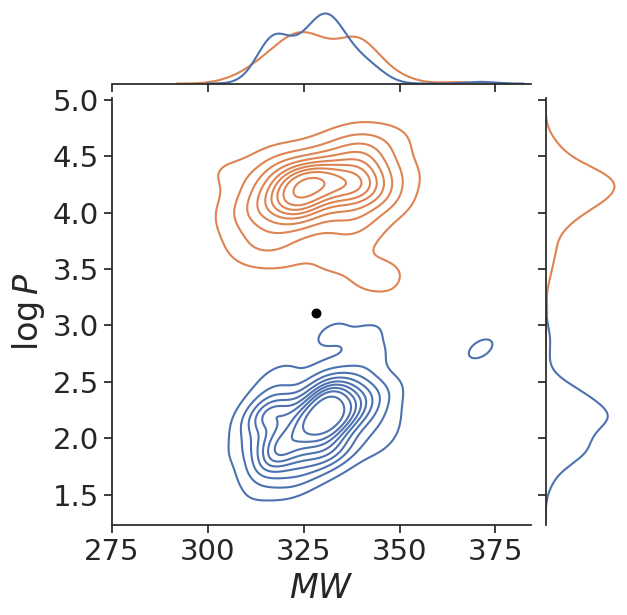

Test molecule: Cc1cc(OCCn2ccc3ccc(OCC(=O)O)cc32)cc(C)c1Cl


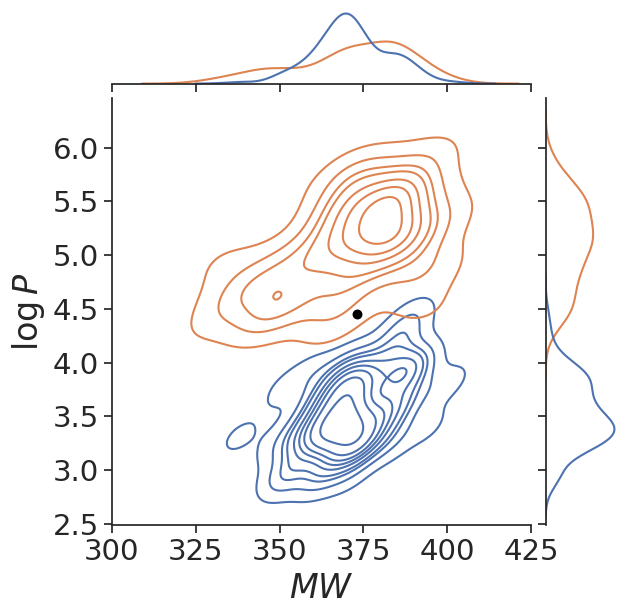

Test molecule: Cc1cc(OCCn2ccc3ccc(OCC(=O)O)cc32)cc(C)c1Cl


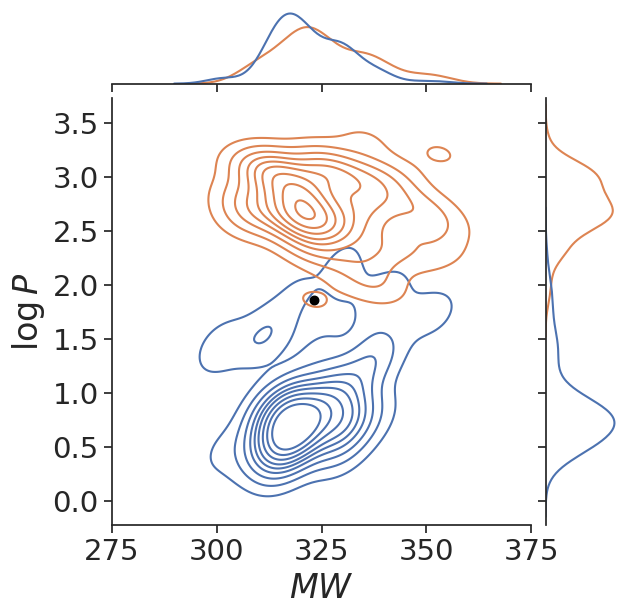

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
sns.set_theme(style="ticks")

# Setting test molecules
test_molecules = ["Cc1ccc(C)c(-c2nnc(NC(=O)c3ccc([N+](=O)[O-])o3)o2)c1",
    "Cc1cc(OCCn2ccc3ccc(OCC(=O)O)cc32)cc(C)c1Cl",
    "COc1ccc(CCNC(=O)C(=O)Nc2ccc(C#N)cc2)cc1",
]

leaving_frag_statistics = defaultdict(dict)
for query_smi in test_molecules:

    # Read result dataframe
    corresponding_data = result_df[result_df["INPUT-MOL-SMI"] == query_smi]
    target_props = corresponding_data["PROPERTY_CONDITION"].unique()
    case = corresponding_data["CASE"].iloc[0]
    input_mol_idx = int(corresponding_data["INPUT-MOL-IDX"].iloc[0] / 2)
    for idx, target_prop in enumerate(target_props):
        prop_value_pairs = target_prop.split(" / ")
        props = [
            prop_value_pair.split(" ")[0] for prop_value_pair in prop_value_pairs
        ]
        target_props[idx] = props

    unique_target_props = []
    for target_prop in target_props:
        if target_prop in unique_target_props:
            continue
        else:
            unique_target_props.append(target_prop)

    assert len(unique_target_props) == 1
    target_props = unique_target_props[0]

    # 0. Properties of original molecule
    corr_case = corresponding_data["CASE"].iloc[0]
    original_smi = corresponding_data["INPUT-MOL-SMI"].iloc[0]
    original_props = calculate_properties(
        original_smi, [prop.lower() for prop in target_props]
    )
    original_x, original_y = (
        original_props[target_props[0]],
        original_props[target_props[1]],
    )

    corr_data_cond_informs = corresponding_data["PROPERTY_CONDITION"].to_list()
    new_corr_data_cond_informs = []
    for cond in corr_data_cond_informs:
        for prop_key, prop_value in DELTA_PROPS.items():
            if prop_key in cond:
                header, tail = cond.split(prop_key)
                cond = prop_value.join([header, tail])
        new_corr_data_cond_informs.append(cond)
    corresponding_data["PROPERTY_CONDITION"] = deepcopy(
        new_corr_data_cond_informs
    )

    # 1. Leaving fragment selection raio
    property_conditions = list(corresponding_data["PROPERTY_CONDITION"].unique())
    for prop_condition in property_conditions:
        leaving_frag_statistics[query_smi][prop_condition] = dict()
        corresponding_condition_data = corresponding_data[
            corresponding_data["PROPERTY_CONDITION"] == prop_condition
        ]
        selected_leaving_frags = corresponding_condition_data[
            "LEAVING-FRAG-SMI"
        ].to_numpy()
        leaving_frags, frequencies = np.unique(
            selected_leaving_frags, return_counts=True
        )
        for frag, freq in zip(leaving_frags, frequencies):
            frag, freq = str(frag), int(freq)
            leaving_frag_statistics[query_smi][prop_condition][frag] = freq

    # 2. Visualization - Kernel density estimation
    g = sns.jointplot(
        data=corresponding_data,
        x=target_props[0].upper(),
        y=target_props[1].upper(),
        hue="PROPERTY_CONDITION",
        kind="kde",
        legend=False,
    )
    # plt.scatter(original_x, original_y, color='black', marker='.', s=150, label='Original Molecule')
    plt.scatter(
        original_x,
        original_y,
        color="black",
        marker=".",
        s=150,
        zorder=10,
    )
    # g.ax_joint.legend_.set_title("")
    g.ax_joint.set_xlabel(r"$\it{MW}$", fontsize=24)
    g.ax_joint.set_ylabel(r"$\log{P}$", fontsize=24)

    # Handling xticks
    x_ticks = list(g.ax_joint.get_xticks())
    x_tick_min, x_tick_max = min(x_ticks), max(x_ticks)
    x_tick_min = 25 * (x_tick_min // 25)
    x_tick_max = 25 * ((x_tick_max // 25) + 1)
    x_ticks = np.arange(x_tick_min, x_tick_max + 1, 25)
    if x_ticks[0] != 300:
        x_ticks = x_ticks[np.where(x_ticks < 400)[0]]
    else:
        x_ticks = x_ticks[np.where(x_ticks <= 425)[0]]

    g.ax_joint.set_xticks(x_ticks)
    g.ax_joint.set_xticklabels(g.ax_joint.get_xticklabels(), fontsize=21)
    g.ax_joint.set_yticklabels(g.ax_joint.get_yticklabels(), fontsize=21)

    g.savefig(f"{save_dir}/{corr_case}_{input_mol_idx}_kde_{query_smi}.png", facecolor='white')
    g.savefig(f"{save_dir}/{corr_case}_{input_mol_idx}_kde_{query_smi}.pdf", format="pdf", dpi=300, facecolor='white')

    print(f"Test molecule: {test_molecules[idx]}")
    plt.show(g)

    with open(f"{save_dir}/leaving_frag_statistics.json", "w") as f:
        json.dump(leaving_frag_statistics, f, indent=4)


#### Analyze properties of generated molecules
The average and variance of controlled properties are calculated.

In [ ]:
# Path setting
target_dir = save_dir               # can be changed to the directory where the csv file is located.
# target_dir = "Feb15_10-25-34"       # example for manual setting
generation_result_file_name = "test_molecules_conditioning_result.csv"      # do not change
leaving_frag_file_name = "leaving_frag_statistics.json"                     # do not change

# Analyzing the generated molecules
# 1. properties mean and variance
print("In order of Mean and variance.", end="\n\n")
target_path = target_dir.joinpath(generation_result_file_name)
mean_var_dict = metric_mean_variance(target_path)
for case, value in mean_var_dict.items():
    if case == "case1":
        print("Case 1: High Mw & QED, but low logP: Maintaining Mw & increasing logP.")
    elif case == "case2":
        print("Case 2: Low QED, Low Mw. Increasing QED & maintaining Mw.")
    elif case == "case3":
        print("Case 3: High QED, but low SA: Maintaining QED & increasing SA.")
    for k, v in value.items():
        print(k, v)
    print()

# 2. leaving frag difference
target_path = target_dir.joinpath(leaving_frag_file_name)
leaving_frag_difference = metric_leaving_frag_difference(target_path)

# 3. Save the calculated metrics
with open(f"{target_dir}/calculated_metrics.json", "w") as fw:
    fw.write(json.dumps(mean_var_dict, indent=4))

for case, value in mean_var_dict.items():
    value["leaving_frag_diff"] = leaving_frag_difference

In order of Mean and variance.

Case 1: High Mw & QED, but low logP: Maintaining Mw & increasing logP.
cond1 {'mw': [3.345269726999087, 15.052307316925122], 'logp': [-0.8450155930000006, 0.4405252849788405]}
cond2 {'mw': [6.687512213565171, 17.924194523119848], 'logp': [0.8143847284768223, 0.421897834888679]}

Case 2: Low QED, Low Mw. Increasing QED & maintaining Mw.
cond1 {'mw': [2.851200247812161, 14.738925274433962], 'qed': [0.06349737597932327, 0.12219856954311727]}
cond2 {'mw': [1.8071556687553516, 14.189333787611154], 'qed': [0.08806783832072994, 0.130158296780288]}

Case 3: High QED, but low SA: Maintaining QED & increasing SA.
cond1 {'qed': [-0.048775838943846586, 0.11289666359260946], 'sa': [-0.2953220284673845, 0.3546067279679893]}
cond2 {'qed': [-0.05013352663884024, 0.11346194439947899], 'sa': [-0.4983949392087574, 0.47163103768156517]}

0th: Cc1ccc(C)c(-c2nnc(NC(=O)c3ccc([N+](=O)[O-])o3)o2)c1 -> leaving fragment count difference: 32
1th: Cc1cc(OCCn2ccc3ccc(OCC(=O)O)cc32)cc

### Leaving fragment statistics for selected test molecules

#### Visualization for removal fragment statistics

In [ ]:
import io
import cairosvg
from collections import defaultdict

import numpy as np
from PIL import Image
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.FragmentMatcher import FragmentMatcher

from brics.brics import BRICSModule


In [ ]:
from IPython.display import display, display_svg

def draw_leaving_frags(smi, leaving_frag_statistics, color_information, save_dir) -> None:
    # Basic settings
    mol = Chem.MolFromSmiles(smi)
    color, max_intensity = (
        color_information["color"],
        color_information["max_intensity"],
    )

    # Calculate weights for each atom
    atom_to_weight = {idx: 0 for idx in range(mol.GetNumAtoms())}
    for leaving_frag, count in leaving_frag_statistics.items():
        # Handling leaving fragment SMARTS
        leaving_frag_mol = Chem.MolFromSmiles(leaving_frag)
        for atom in leaving_frag_mol.GetAtoms():
            if atom.GetSymbol() == "*":
                atom.SetIsotope(0)
        frag_smarts_with_dummy = Chem.MolToSmiles(leaving_frag_mol)

        frag_smarts_copy = frag_smarts_with_dummy
        while "*" in frag_smarts_copy:
            leaving_frag_mol = Chem.MolFromSmiles(frag_smarts_copy)
            for atom in leaving_frag_mol.GetAtoms():
                if atom.GetSymbol() == "*":
                    dummy_atom_idx = atom.GetIdx()

            leaving_frag_rwmol = Chem.RWMol(leaving_frag_mol)
            BRICSModule.remove_dummy_atom(leaving_frag_rwmol, dummy_atom_idx)
            leaving_frag_mol = leaving_frag_rwmol.GetMol()
            frag_smarts_copy = Chem.MolToSmiles(leaving_frag_mol)

        frag_smarts_without_dummy = frag_smarts_copy

        matcher_with_dummy, matcher_without_dummy = FragmentMatcher(), FragmentMatcher()
        matcher_with_dummy.Init(frag_smarts_with_dummy)
        matcher_without_dummy.Init(frag_smarts_without_dummy)

        matches_with_dummy = matcher_with_dummy.GetMatches(mol)
        matches_without_dummy = matcher_without_dummy.GetMatches(mol)

        if len(matches_with_dummy) == 0:
            raise ValueError("No matches found")

        elif len(matches_with_dummy) == 1:
            if len(matches_without_dummy) == 0:
                if leaving_frag == "[3*]Oc1ccc2ccn([9*])c2c1":
                    match = (14, 13, 12, 11, 10, 9, 8, 7, 20, 19)
                elif leaving_frag == "[9*]n1ccc2ccc([16*])cc21":
                    match = (13, 12, 11, 10, 9, 8, 7, 20, 19)
                else:
                    raise ValueError("Another case")
            elif len(matches_without_dummy) == 1:
                match_with_dummy = matches_with_dummy[0]
                match_without_dummy = matches_without_dummy[0]
                match = tuple(
                    filter(lambda x: x in match_with_dummy, match_without_dummy)
                )
            elif len(matches_without_dummy) >= 2:
                raise ValueError("Another case2")

        elif len(matches_with_dummy) >= 2:
            # NOTE: Manual handling is required. (23.09.14)
            if smi == "Cc1cc(OCCn2ccc3ccc(OCC(=O)O)cc32)cc(C)c1Cl":  # 2nd molecule
                if leaving_frag == "[3*]OCC[8*]":
                    match = (6, 5, 4)
                elif leaving_frag == "[3*]O[3*]":
                    match = (14,)
                elif leaving_frag == "[4*]CC[8*]":
                    match = (5, 6)
            elif smi == "COc1ccc(CCNC(=O)C(=O)Nc2ccc(C#N)cc2)cc1":  # 3rd molecule
                if leaving_frag == "[16*]c1ccc([16*])cc1":
                    match = (2, 3, 4, 5, 22, 23)
                elif leaving_frag == "[1*]C(=O)C(=O)N[5*]":
                    match = (13, 11, 12, 9, 10)
                elif leaving_frag == "[4*]CC[8*]":
                    match = (6, 7)
                elif leaving_frag == "[5*]NCC[8*]":
                    match = (6, 7, 8)
                elif leaving_frag == "[5*]N[5*]":
                    match = (8,)

            assert match in matches_without_dummy, "match is not matched."

        for idx in match:
            atom_to_weight[idx] += int(count)

    # NOTE: the atom color weight is normalized by the maximum weight.
    # max_weight = 100
    max_weight = max(atom_to_weight.values())
    atom_to_weight = {k: v / max_weight for k, v in atom_to_weight.items()}

    atom_highlights = defaultdict(list)
    atom_rads = {}
    for atom in mol.GetAtoms():
        atom_idx = atom.GetIdx()
        atom_color = deepcopy(color)
        atom_color = list(1.0 - (np.array(atom_color)* (-1) + 1.0) * max_intensity * atom_to_weight[atom_idx])
        atom_color.append(1.0)

        atom_highlights[atom_idx].append(tuple(atom_color))
        atom_rads[atom_idx] = 0.38

    bond_highlights = defaultdict(list)
    bond_rads = {}
    for bond in mol.GetBonds():
        atom_idx1 = bond.GetBeginAtomIdx()
        atom_idx2 = bond.GetEndAtomIdx()

        bond_idx = mol.GetBondBetweenAtoms(atom_idx1, atom_idx2).GetIdx()
        bond_color = color.copy()
        bond_weight = min(atom_to_weight[atom_idx1], atom_to_weight[atom_idx2])

        bond_color = list(1.0 - (np.array(bond_color)* (-1) + 1.0) * max_intensity * bond_weight)
        bond_color.append(1.0)

        bond_highlights[bond_idx].append(tuple(bond_color))
        bond_rads[bond_idx] = 1

    bond_highlights = dict(bond_highlights)
    
    # Using SVG for visualization
    d2d = Draw.rdMolDraw2D.MolDraw2DSVG(-1, -1)
    draw_options = d2d.drawOptions()
    draw_options.useBWAtomPalette()
    d2d.DrawMoleculeWithHighlights(
        mol=mol,
        legend="",
        highlight_atom_map=dict(atom_highlights),
        highlight_bond_map=dict(bond_highlights),
        highlight_radii=atom_rads,
        highlight_linewidth_multipliers={}
        # highlight_linewidth_multipliers=bond_rads,
    )
    d2d.FinishDrawing()
    cairosvg.svg2pdf(
        bytestring=d2d.GetDrawingText().encode(),
        write_to=f"{save_dir}/removal_{smi_idx+1}th_mol_{cond_idx+1}th_condition.pdf",
        dpi=300
    )
    display_svg(d2d.GetDrawingText(), raw=True)

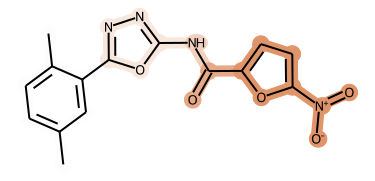

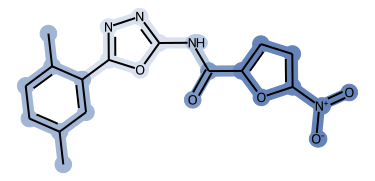

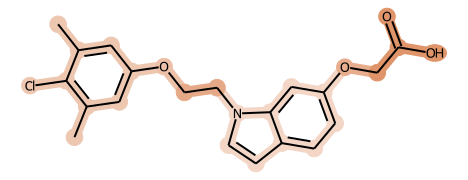

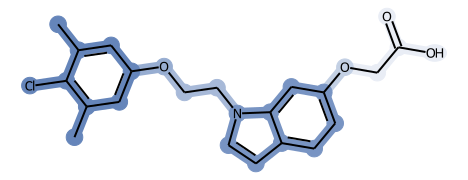

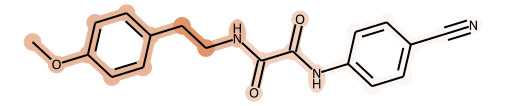

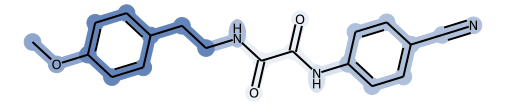

In [ ]:
# Read leaving frag statistics
with open(f"{save_dir}/leaving_frag_statistics.json", "r") as f:
    leaving_frag_statistics = json.load(f)

# Color setting - RGB
orange = [225, 149, 106]
blue = [85, 121, 180]

orange_max_intensity = 1.0
blue_max_intensity = 0.9

orange = (np.array(orange) * np.array([1 / 256, 1 / 256, 1 / 256])).tolist()
blue = (np.array(blue) * np.array([1 / 256, 1 / 256, 1 / 256])).tolist()

color_list = [orange, blue]
max_intensity_list = [orange_max_intensity, blue_max_intensity]

# Property control conditions
conditions = [
    "$\\Delta Mw$ 0.00 / $\\Delta logP$ 1.00",
    "$\\Delta Mw$ 0.00 / $\\Delta logP$ -1.00",
]

# Draw Figures
for smi_idx, smi in enumerate(test_molecules):
    for cond_idx, condition in enumerate(conditions):
        color_inform = {
            "color": color_list[cond_idx],
            "max_intensity": max_intensity_list[cond_idx],
        }
        statistics = leaving_frag_statistics[smi][condition]
        draw_leaving_frags(smi, statistics, color_inform, save_dir)